In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


# ***Transpose Convolution from scratch***

In [ ]:
import numpy as np

In [ ]:
def trans_conv(img_origin, padding, kernel, stride):
    k_size = kernel.shape[0]
    z = stride - 1
    p = k_size - padding - 1
    s_ = 1
    new_img_rows = img_origin.shape[0] + z*(img_origin.shape[0] - 1) + 2*p
    new_img_cols = img_origin.shape[1] + z*(img_origin.shape[1] - 1) + 2*p
    new_img = np.zeros((new_img_rows, new_img_cols))
    m = 0
    for i in range(p, new_img.shape[0]-p, z+1):
        k = 0
        for j in range(p, new_img.shape[1]-p, z+1):
            new_img[i][j] = img_origin[m][k]
            k += 1
        m += 1

    #   Conv
    trans_img = []
    for i in range(0, new_img.shape[0]-p-1, s_):
        lst = []
        for j in range(0, new_img.shape[1]-p-1, s_):
            lst.append(np.sum(kernel * new_img[i:i+k_size, j:j+k_size]))
        trans_img.append(lst)
    return np.asarray(trans_img)

In [ ]:
img = np.random.randint(0, 10, (4, 4))
print(img)

[[5 8 8 2]
 [0 1 8 6]
 [1 7 3 9]
 [0 8 9 8]]


In [ ]:
kernel = np.random.randint(0, 2, (3, 3))

In [ ]:
stride = 2
padding = 1
new = trans_conv(img, padding, kernel, stride)
print(new)

[[ 5.  8.  8.  8.  8.  2.  2.]
 [ 5.  1.  9.  8. 16.  6.  8.]
 [ 0.  1.  1.  8.  8.  6.  6.]
 [ 1.  7.  8.  3. 11.  9. 15.]
 [ 1.  7.  7.  3.  3.  9.  9.]
 [ 1.  8. 15.  9. 12.  8. 17.]
 [ 0.  8.  8.  9.  9.  8.  8.]]


# ***II. Denoise CIFAR-10 by AutoEncoder***

In [ ]:
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, Conv2DTranspose
from keras.callbacks import ModelCheckpoint

In [ ]:
def add_noise(img, noise_factor):
    X = img + np.random.randn(*img.shape) * noise_factor
    X = X.clip(0, 1)
    return X

In [ ]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_train = X_train / 255.0
X_test = X_test.astype('float32')
X_test = X_test / 255.0
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
noise_factor = 0.1
X_train_noise = add_noise(X_train, noise_factor)
X_test_noise = add_noise(X_test, noise_factor)

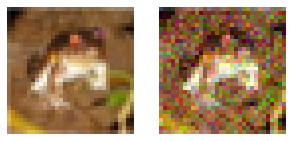

In [ ]:
fig = plt.figure(figsize = (5, 3))
(ax1, ax2) = fig.subplots(1, 2)
ax1.imshow(X_train[0], cmap = 'gray')
ax1.axis('off')
ax2.imshow(X_train_noise[0], cmap = 'gray')
ax2.axis('off');

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_normal', padding = 'same', strides = 2, activation = 'relu', input_shape = (32, 32, 3)))
model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_normal', padding = 'same', strides = 2, activation = 'relu'))
model.add(Conv2D(128, (3, 3), kernel_initializer = 'he_normal', padding = 'same', strides = 2, activation = 'relu'))

model.add(Conv2DTranspose(128, (3, 3), kernel_initializer = 'he_normal', padding = 'same', strides = 2, activation = 'relu'))
model.add(Conv2DTranspose(64, (3, 3), kernel_initializer = 'he_normal', padding = 'same', strides = 2, activation = 'relu'))
model.add(Conv2DTranspose(32, (3, 3), kernel_initializer = 'he_normal', padding = 'same', strides = 2, activation = 'relu'))

model.add(Conv2D(3, (3, 3), kernel_initializer = 'he_normal', padding = 'same', activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 32)      

In [ ]:
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['acc'])

In [ ]:
checkpoint = ModelCheckpoint(filepath = 'best_model.h5', verbose = 1, save_best_only = True)
model.fit(X_train_noise, X_train, epochs = 20, batch_size = 32, callbacks = [checkpoint])

Epoch 1/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0064 - acc: 0.7077
Epoch 2/20
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0031 - acc: 0.7634
Epoch 3/20
1563/1563 [==============================] - 21s 14ms/step - loss: 0.0027 - acc: 0.7727
Epoch 4/20
1563/1563 [==============================] - 21s 14ms/step - loss: 0.0025 - acc: 0.7777
Epoch 5/20
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0023 - acc: 0.7808
Epoch 6/20
1563/1563 [==============================] - 21s 14ms/step - loss: 0.0022 - acc: 0.7828
Epoch 7/20
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0021 - acc: 0.7853
Epoch 8/20
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0021 - acc: 0.7867
Epoch 9/20
1563/1563 [==============================] - 21s 14ms/step - loss: 0.0020 - acc: 0.7880
Epoch 10/20
1563/1563 [==============================] - 21s 14ms/step - loss: 0.0020 - acc: 0.7891
Epoch 11/

In [ ]:
preds = model.predict(X_test_noise)

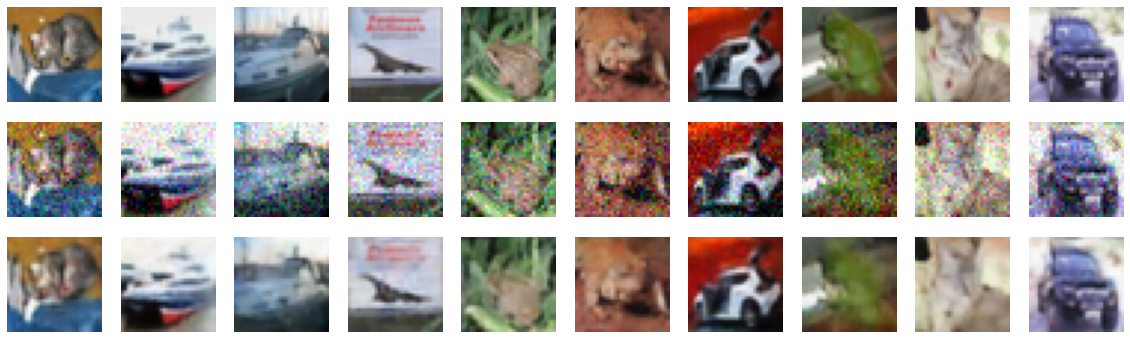

In [ ]:
plt.figure(figsize = (20, 6))
for i in range(10):
  plt.subplot(3, 10, i + 1)
  plt.imshow(X_test[i], cmap = 'gray')
  plt.axis('off')
          
  plt.subplot(3, 10, 10 + i + 1)
  plt.imshow(X_test_noise [i], cmap = 'gray')
  plt.axis('off')
          
  plt.subplot(3, 10, 20 + i + 1)
  plt.imshow(preds[i], cmap = 'gray')
  plt.axis('off')
plt.show()

# ***III. Dimentional Reduction with PCA, Convolution AutoEncoder, Neural Network AutoEncoder***

## ***1. Principal Component Analysis (PCA)***

Link: https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python

In [106]:
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [107]:
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [108]:
print(Y_train.shape)
print(Y_test.shape)

(50000, 1)
(10000, 1)


In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [110]:
classes = np.unique(Y_train)
no_class = len(classes)
print('Total number of class:', no_class)
print(classes)

Total number of class: 10
[0 1 2 3 4 5 6 7 8 9]


In [111]:
X_train = X_train/255.0
np.min(X_train), np.max(X_train)

(0.0, 1.0)

In [112]:
X_flatten = X_train.reshape(-1, 3072)
feature_colms = ['Pixel'+str(i) for i in range(X_flatten.shape[1])]
cifar_df = pd.DataFrame(X_flatten, columns = [feature_colms])
cifar_df['Labels'] = Y_train 
print(cifar_df.head())
print(cifar_df.shape)

     Pixel0    Pixel1    Pixel2    Pixel3  ... Pixel3069 Pixel3070 Pixel3071 Labels
0  0.231373  0.243137  0.247059  0.168627  ...  0.482353  0.360784  0.282353      6
1  0.603922  0.694118  0.733333  0.494118  ...  0.560784  0.521569  0.564706      9
2  1.000000  1.000000  1.000000  0.992157  ...  0.313725  0.337255  0.329412      9
3  0.109804  0.098039  0.039216  0.145098  ...  0.282353  0.254902  0.180392      4
4  0.666667  0.705882  0.776471  0.658824  ...  0.286275  0.301961  0.313725      1

[5 rows x 3073 columns]
(50000, 3073)


In [113]:
pca_cifar = PCA(n_components = 2)
principalComponent_cifar = pca_cifar.fit_transform(cifar_df.iloc[:, :-1])
type(principalComponent_cifar)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


numpy.ndarray

In [114]:
#   Convert printcipal components for each of 50000 images from numpy array to pandas DataFrame
principalComponent_cifar_df = pd.DataFrame(principalComponent_cifar, columns = ['CP_01', 'CP_02'])
principalComponent_cifar_df['Y'] = Y_train
principalComponent_cifar_df.head()

,CP_01,CP_02,Y
0,-6.401018,2.729039,6
1,0.829783,-0.949944,9
2,7.730200,-11.522101,9
3,-10.347817,0.010738,4
4,-2.625651,-4.969241,1


In [115]:
#   Find the explained_variance_ratio
pca_cifar.explained_variance_ratio_

array([0.2907663 , 0.11253144])

$=>$ Well, it looks like a decent amount of information was retained by the principal components 1 and 2, given that the data was projected from 3072 dimensions to a mere two principal components.

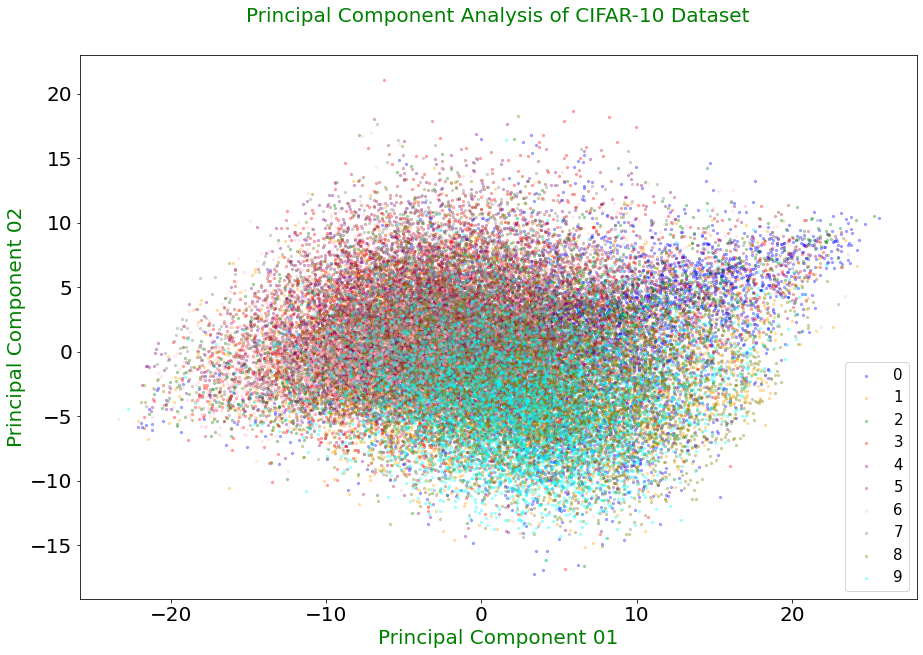

In [138]:
plt.figure(figsize = (15, 10))
plt.xlabel('Principal Component 01', fontsize = 20, c = 'g')
plt.ylabel('Principal Component 02', fontsize = 20, c = 'g')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Principal Component Analysis of CIFAR-10 Dataset", fontsize=20, c = 'g', y = 1.05)
targets = [i for i in range(no_class)]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for target, color in zip(targets, colors):
    keepIndex = principalComponent_cifar_df['Y'] == target
    plt.scatter(principalComponent_cifar_df.loc[keepIndex, 'CP_01'],
                principalComponent_cifar_df.loc[keepIndex, 'CP_02'], 
                c = color, label = target, alpha = 0.3, s = 5)
plt.legend(loc = 'lower right', prop = {'size': 15})
plt.show()

## ***2. Convolution AutoEncoder***

In [22]:
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, BatchNormalization, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

In [24]:
X_train = X_train.astype('float32')
X_train = X_train / 255.0
X_test = X_test.astype('float32')
X_test = X_test / 255.0
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [25]:
#   Encoder block
def conv_block(x, no_kernel, k_size, pad = 'same'):
    x = Conv2D(no_kernel, (k_size, k_size), padding = pad, activation = 'relu')(x)
    x = MaxPooling2D()(x)
    return x

#   Dencoder block
def deconv_block(x, no_kernel, k_size, pad = 'same'):
    x = Conv2D(no_kernel, (k_size, k_size), padding = pad, activation = 'relu')(x)
    x = UpSampling2D()(x)
    return x

In [26]:
input = Input(shape = (32, 32, 3))

#   Encoder block
conv_block1 = conv_block(input, 64, 3)
conv_block2 = conv_block(conv_block1, 128, 3)

#   Dense layer
fcHead = Flatten()(conv_block2)
fcHead = Dense(256, activation = 'swish', kernel_initializer = 'he_normal')(fcHead)
latent_reduction = Dense(2, activation = 'swish', kernel_initializer = 'he_normal')(fcHead)
fcHead = Dense(256, activation = 'swish', kernel_initializer = 'he_normal')(latent_reduction)
fcHead = Dense(8192, activation = 'swish', kernel_initializer = 'he_normal')(fcHead)
fcHead = Reshape((8, 8, 128))(fcHead)

#   Dencoder block
deconv_block2 = deconv_block(fcHead, 64, 3)
deconv_block3 = deconv_block(deconv_block2, 32, 3)

output = Conv2D(3, (3, 3), padding = 'same', activation = 'sigmoid')(deconv_block3)

In [27]:
model = Model(input, output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0   

In [32]:
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['acc'])

In [36]:
model.fit(X_train, X_train, epochs = 10, validation_data = (X_test, X_test), batch_size = 32)

Epoch 1/10
1561/1563 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.4960
Epoch 00001: val_loss improved from 0.03683 to 0.03647, saving model to best_model.h5
1563/1563 [==============================] - 33s 21ms/step - loss: 0.0365 - acc: 0.4960 - val_loss: 0.0365 - val_acc: 0.5005
Epoch 2/10
1562/1563 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.5017
Epoch 00002: val_loss improved from 0.03647 to 0.03620, saving model to best_model.h5
1563/1563 [==============================] - 35s 22ms/step - loss: 0.0364 - acc: 0.5017 - val_loss: 0.0362 - val_acc: 0.5126
Epoch 3/10
1562/1563 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.5055
Epoch 00003: val_loss did not improve from 0.03620
1563/1563 [==============================] - 34s 22ms/step - loss: 0.0363 - acc: 0.5055 - val_loss: 0.0364 - val_acc: 0.5132
Epoch 4/10
1561/1563 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.5096
Epoch 00004: val_loss improved

In [37]:
encoder = Model(input, latent_reduction)
encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0   

In [43]:
#   Save model
encoder.save('model_encoder.h5')

In [44]:
model_encoder = load_model('model_encoder.h5')
model_encoder.compile(loss = 'mse', optimizer = 'adam', metrics = ['acc'])

In [45]:
image_reduction = encoder.predict(X_test)
print(image_reduction.shape)

(10000, 2)


In [46]:
df = pd.DataFrame(image_reduction, columns = ['D1', 'D2'])
df['labels'] = Y_test
df.head()

,D1,D2,labels
0,0.025119,-0.096210,3
1,-0.223458,-0.101222,8
2,-0.157648,-0.095385,8
3,-0.186228,-0.078611,0
4,0.110170,-0.081718,6


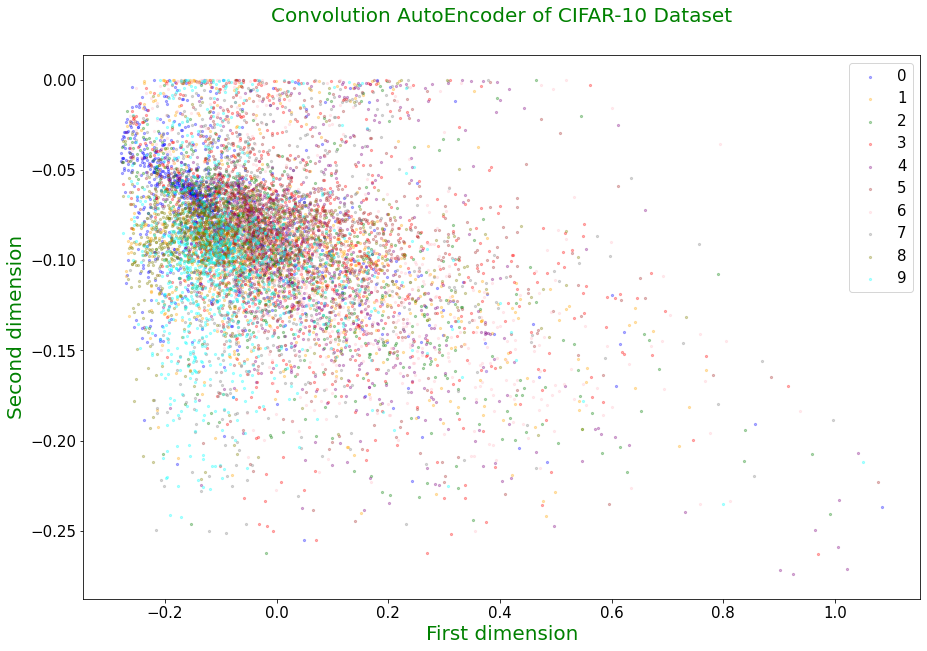

In [48]:
plt.figure(figsize = (15, 10))
plt.xlabel('First dimension', fontsize = 20, c = 'g')
plt.ylabel('Second dimension', fontsize = 20, c = 'g')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Convolution AutoEncoder of CIFAR-10 Dataset", fontsize=20, c = 'g', y = 1.05)
targets = [i for i in range(10)]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for target, color in zip(targets, colors):
    keepIndex = df['labels'] == target
    plt.scatter(df.loc[keepIndex, 'D1'],
                df.loc[keepIndex, 'D2'], 
                c = color, label = target, alpha = .3, s = 5)
plt.legend(loc = 'upper right', prop = {'size': 15})
plt.show()

## ***3. Neural Network AutoEncoder***

In [49]:
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, BatchNormalization, Flatten, Dense, Reshape, Activation, LeakyReLU
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

In [65]:
def dense_block(x, no_node):
    x = Dense(no_node, kernel_initializer = 'he_uniform')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x

In [76]:
inputs = Input(shape = (32, 32, 3))
flatten = Flatten()(inputs)

#   Encoder block
encode_block1 = dense_block(flatten, 1024)
encode_block2 = dense_block(encode_block1, 64)
          
bottleneck = dense_block(encode_block2, 2)

#   Decoder block
decode_block1 = dense_block(bottleneck, 64)
decode_block2 = dense_block(decode_block1, 1024)
final_layer = dense_block(decode_block2, 3072)

reshape = Reshape((32, 32, 3))(final_layer)
# outputs = Conv2D(3, (3, 3), activation = 'sigmoid', padding = 'same')(reshape)
outputs = Activation('sigmoid')(reshape)

In [77]:
model_nn = Model(inputs, outputs)
model_nn.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_8 (Flatten)         (None, 3072)              0         
                                                                 
 dense_58 (Dense)            (None, 1024)              3146752   
                                                                 
 dropout_22 (Dropout)        (None, 1024)              0         
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_59 (Dense)            (None, 64)                65600     
                                                                 
 dropout_23 (Dropout)        (None, 64)                0   

In [80]:
model_nn.compile(loss = 'mse', optimizer = 'adam')

In [81]:
model_nn.fit(X_train, X_train, epochs = 10, validation_data = (X_test, X_test), batch_size = 32)

Epoch 1/10
1563/1563 [==============================] - 14s 8ms/step - loss: 18481.1172 - val_loss: 18631.0762
Epoch 2/10
 246/1563 [===>..........................] - ETA: 9s - loss: 18566.4453

KeyboardInterrupt: ignored